In [1]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import variation,kurtosis,skew,gmean,hmean
%matplotlib inline
plt.style.use('ggplot')
from pywt import wavedec

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.decomposition import PCA

In [3]:
from numba.typed import List
from numba import jit, njit, vectorize

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [5]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [6]:
def signal_power(data):
    p = [ abs(x)**2 for x in data ]
    x = np.sum(p)
    return x

In [7]:
def abs_value(data):
    ab = [abs(x) for x in data ]
    x = np.sum(ab)
    return x  

# Feature extraction

In [8]:
def Features(window):# wavelet coefficients using Daubechies 2 and 3 wavelet mother
    wind = window.iloc[:, :-1]
    win = np.array(wind)
    features = []
        
    coef = wavedec(win, 'db3', level=5)
    cA5, cD5, cD4, cD3, cD2, cD1 = coef
    
    
    coeffs = wavedec(win, 'db2', level=5)
    cE5, cB5, cB4, cB3, cB2, cB1 = coeffs
    
    
    
    features.append(signal_power(cD5))
    features.append(signal_power(cD4))
    features.append(signal_power(cB5))
    features.append(signal_power(cB4))
    features.append(signal_power(cB3))
    features.append(signal_power(cB2))
    features.append(signal_power(cB1))
    features.append(abs_value(cB5))
    features.append(abs_value(cB4))
    features.append(abs_value(cB3))
    features.append(abs_value(cB2))
    features.append(abs_value(cB1))
    
 

    
    features = np.hstack(features).tolist()
    
    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [9]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap=False):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [10]:
def Preprocessing(dataset_path, overlapping):
    feature_function = Features
    win_size = 3

    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    print(feature_function.__name__)

    ACC = []
    GYR = []
    MAG = []
    QUAD = []
    ALL = []

    for subject in range(1,18):
        file_path = dataset_path + '\subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        gyr_cols = []
        mag_cols = []
        quad_cols = []
        all_cols = []
        
#########################################################################################################################
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ACC.append(transformed_db)
#########################################################################################################################
        for i in range(5, 117, 13):# indices of gyr
            indices = list(range(i, i + 3))
            gyr_cols.extend(indices)

        gyr_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=gyr_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        GYR.append(transformed_db)
#########################################################################################################################        
        for i in range(8, 117, 13):# indices of mag
            indices = list(range(i, i + 3))
            mag_cols.extend(indices)

        mag_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=mag_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        MAG.append(transformed_db)
#########################################################################################################################
        for i in range(11, 117, 13):# indices of quad
            indices = list(range(i, i + 4))
            quad_cols.extend(indices)

        quad_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=quad_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        QUAD.append(transformed_db)
#########################################################################################################################
        for i in range(2, 117, 13):# indices of all
            indices = list(range(i, i + 13))
            all_cols.extend(indices)

        all_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=all_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        ALL.append(transformed_db)
#########################################################################################################################
    #final_dataset = pd.DataFrame()
    ACC_dataset = pd.DataFrame()
    GYR_dataset = pd.DataFrame()
    MAG_dataset = pd.DataFrame()
    QUAD_dataset= pd.DataFrame()
    ALL_dataset = pd.DataFrame()
    ACC_dataset = ACC_dataset.append(ACC, ignore_index=True)
    GYR_dataset = GYR_dataset.append(GYR, ignore_index=True)
    MAG_dataset = MAG_dataset.append(MAG, ignore_index=True)
    QUAD_dataset = QUAD_dataset.append(QUAD, ignore_index=True)
    ALL_dataset = ACC_dataset.append(ALL, ignore_index=True)
    return ACC_dataset,GYR_dataset,MAG_dataset,QUAD_dataset,ALL_dataset
   

In [11]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0
    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print('Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [12]:
def classifier(dataset, model):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1]
    X = np.array(X)
    
    
    
    Y = dataset.iloc[:, -1].values
    Y = np.array(Y)
   

    for model_name, mod in model.items():
        f1 = 0

        f1 = subject_cross_validation(X, Y, groups, mod)

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]


        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(model.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)

    accuracy = final[1][1]
    
    return accuracy

In [13]:
mod = {'RF': RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)}

In [14]:
%%time
dataset_csv_path = r"D:\projec\proj\data"

overlapping = 1  # input 0 for non overlapping, 1 for overlapping

ACC, GYR,MAG,QUAD,ALL = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

Start for win size 3
Features


C:\Users\BKY\anaconda3\lib\site-packages\pywt\_multilevel.py:45: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


Wall time: 39min 10s


In [15]:
ACC.head(10)

,group,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,28380.385261,26791.066311,27572.129791,14615.041348,6205.431468,11504.016490,88714.996489,2348.389801,2315.160504,1968.056609,3470.119590,12650.778252,1
1,1,29193.176805,27970.517703,28866.005432,15139.667054,6262.285320,11862.875932,87953.224672,2437.253398,2364.785842,1997.119132,3532.594816,12576.016790,1
2,1,29973.289408,29209.474756,30234.872351,15995.703924,6268.414472,12157.056069,87736.285298,2532.763181,2467.611373,2022.451790,3552.833902,12555.957478,1
3,1,27403.085544,23837.376422,23312.445010,13465.889512,5473.117652,11983.966612,87019.019276,2250.300752,2330.152606,1892.858374,3500.017876,12515.161901,1
4,1,25284.635788,20871.456972,21541.602259,12308.023783,4941.136684,13220.704714,87226.112947,2137.350425,2214.829273,1777.391941,3603.215343,12547.040715,1
5,1,22747.719151,22617.269856,22323.068522,13817.092686,5586.142568,14785.908802,89192.123334,2126.308399,2299.119812,1866.532249,3782.985401,12679.500825,1
6,1,20270.027808,23460.019278,21939.961344,14425.342563,5734.195482,15579.818393,87660.281069,2130.955244,2338.154094,1912.132002,3919.832331,12497.282289,1
7,1,17933.173672,23016.403567,21084.296964,14209.287492,6050.821909,16530.180562,87734.337508,2113.689919,2328.715184,1979.651766,4017.916773,12414.063268,1
8,1,15911.507768,23954.721668,21692.572707,14985.876281,6566.543227,17947.070229,87808.232142,2169.791822,2400.338600,2087.144681,4158.800181,12382.099995,1
9,1,12624.492485,21064.693553,18453.602942,13744.912390,6368.105437,17975.446046,86131.260045,1999.796579,2270.650236,2025.081619,4152.247932,12238.029476,1


In [16]:
GYR.head(10)

,group,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,119.891918,912.027605,670.468194,190.474294,470.585302,521.060936,1286.057251,316.319302,223.016241,391.343499,529.893607,1012.385101,1
1,1,121.804335,870.864570,625.511738,173.360057,400.648553,546.447749,1271.735272,303.225246,212.284483,368.412191,529.476820,993.503097,1
2,1,94.383465,586.477359,386.036270,122.223154,338.619502,503.888729,1154.523863,240.442268,178.548636,339.851361,517.089274,990.326759,1
3,1,130.910521,628.288879,452.896387,184.666232,449.251455,543.646909,1286.813913,278.222783,212.433106,390.276045,544.768730,1061.284634,1
4,1,197.022365,902.027057,714.701458,246.040960,524.725703,575.109984,1506.076978,355.418835,248.067527,431.748966,569.771709,1148.421759,1
5,1,244.882136,1043.316003,746.569927,272.656934,580.851561,634.452716,1665.203921,365.730263,273.522415,469.274023,623.657864,1244.870004,1
6,1,374.269162,1111.085884,944.796281,331.201169,624.591685,756.304743,1855.541014,410.230069,300.878532,493.212444,677.949169,1315.754175,1
7,1,409.574244,1146.755541,990.208663,381.540431,629.751767,814.410758,2219.204824,430.346381,320.662052,509.071075,707.507187,1435.990730,1
8,1,386.037681,963.651104,754.346404,366.792969,634.670400,826.993590,2281.649717,372.988420,317.315399,517.887380,736.460528,1505.636511,1
9,1,439.762510,1457.330907,1188.795600,438.033958,808.995881,921.165154,2572.367520,475.062733,351.661662,586.940271,771.103209,1595.861647,1


In [17]:
MAG.head(10)

,group,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,55.827902,111.923761,98.716731,91.232369,40.730400,126.264568,315.410722,153.770410,176.574050,169.865134,359.628535,777.105483,1
1,1,59.234243,125.716752,102.168831,101.989000,44.254251,126.860287,311.349043,157.649228,190.652138,176.987227,364.088048,770.356020,1
2,1,57.501810,121.424005,94.952622,103.332219,43.810491,122.725247,314.520418,148.312596,193.845210,175.552033,353.797003,771.395130,1
3,1,52.565052,101.090671,80.448614,89.343112,39.472107,118.486399,320.817302,134.466529,179.105808,164.222925,341.975684,777.167712,1
4,1,47.435385,86.827964,72.575219,82.428374,36.620119,128.316286,326.893829,126.531689,172.251125,158.165023,351.454035,782.767618,1
5,1,44.623668,107.219189,83.537408,87.060530,41.068969,138.929334,329.473328,136.898392,176.422812,164.189722,367.279683,780.356608,1
6,1,46.239939,132.212448,88.519831,93.807888,47.799706,143.200203,329.415031,147.680722,184.509571,175.650793,378.693257,771.785103,1
7,1,47.745087,150.230612,87.018660,102.796647,50.866734,146.880228,334.092567,145.851143,196.745976,181.837808,383.106158,767.894482,1
8,1,52.157894,154.210282,103.104352,99.212290,49.567657,145.993481,358.475291,159.803643,191.266248,178.041698,375.176174,783.978486,1
9,1,48.269775,140.792950,91.280844,88.521724,46.658506,150.242108,394.630779,148.709027,181.244942,172.043210,375.253321,807.342287,1


In [18]:
QUAD.head(10)

,group,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,83.105415,337.169732,133.637327,223.816351,323.487189,528.602587,396.370066,244.621192,332.800043,465.303941,790.196170,910.908671,1
1,1,88.561185,358.531696,138.937504,224.473746,322.961767,528.434513,404.067049,252.945763,334.332888,463.982543,790.361713,920.056515,1
2,1,85.290652,346.995140,133.973725,219.016618,321.171876,531.304319,408.413097,247.593755,330.701243,463.238061,793.885076,923.575084,1
3,1,76.060923,318.995788,126.725091,212.901533,317.808796,533.654762,404.025986,237.005299,325.124361,461.362452,793.466954,916.981328,1
4,1,70.899815,308.988274,128.548612,217.479899,315.136543,538.934533,396.741842,236.679963,328.772592,460.337712,795.840269,904.367847,1
5,1,75.323455,318.522157,136.394549,221.326062,312.346775,546.185979,395.686005,243.894912,332.912979,458.652320,796.485415,906.288932,1
6,1,78.716610,330.696699,143.195579,222.461120,307.770560,555.945420,400.336834,251.517268,335.235292,454.335848,798.546702,915.771237,1
7,1,80.329186,341.390995,147.792068,225.413766,303.682839,566.547929,409.252687,258.623210,339.635712,451.290291,806.513502,924.685567,1
8,1,76.112897,322.748960,143.732020,218.274287,298.658526,574.489812,415.701215,252.823140,335.100505,449.173749,808.332095,931.609233,1
9,1,69.930934,308.171648,142.640991,217.560973,295.794044,576.877199,418.353565,250.710292,335.518687,447.921236,807.848627,934.451401,1


In [19]:
ALL = ALL.fillna(0)
ALL.head(10)

,group,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,28380.385261,26791.066311,27572.129791,14615.041348,6205.431468,11504.016490,88714.996489,2348.389801,2315.160504,1968.056609,3470.119590,12650.778252,1
1,1,29193.176805,27970.517703,28866.005432,15139.667054,6262.285320,11862.875932,87953.224672,2437.253398,2364.785842,1997.119132,3532.594816,12576.016790,1
2,1,29973.289408,29209.474756,30234.872351,15995.703924,6268.414472,12157.056069,87736.285298,2532.763181,2467.611373,2022.451790,3552.833902,12555.957478,1
3,1,27403.085544,23837.376422,23312.445010,13465.889512,5473.117652,11983.966612,87019.019276,2250.300752,2330.152606,1892.858374,3500.017876,12515.161901,1
4,1,25284.635788,20871.456972,21541.602259,12308.023783,4941.136684,13220.704714,87226.112947,2137.350425,2214.829273,1777.391941,3603.215343,12547.040715,1
5,1,22747.719151,22617.269856,22323.068522,13817.092686,5586.142568,14785.908802,89192.123334,2126.308399,2299.119812,1866.532249,3782.985401,12679.500825,1
6,1,20270.027808,23460.019278,21939.961344,14425.342563,5734.195482,15579.818393,87660.281069,2130.955244,2338.154094,1912.132002,3919.832331,12497.282289,1
7,1,17933.173672,23016.403567,21084.296964,14209.287492,6050.821909,16530.180562,87734.337508,2113.689919,2328.715184,1979.651766,4017.916773,12414.063268,1
8,1,15911.507768,23954.721668,21692.572707,14985.876281,6566.543227,17947.070229,87808.232142,2169.791822,2400.338600,2087.144681,4158.800181,12382.099995,1
9,1,12624.492485,21064.693553,18453.602942,13744.912390,6368.105437,17975.446046,86131.260045,1999.796579,2270.650236,2025.081619,4152.247932,12238.029476,1


In [20]:
%%time
print('ACC_accuracy = ', )
ACC_accuracy = classifier(dataset=ACC, model=mod)
ACC_accuracy 

ACC_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.7038461538461539
Model- 2  -  f1 score:  0.8244624603454352
Model- 3  -  f1 score:  0.5584
Model- 4  -  f1 score:  0.7999082147774208
Model- 5  -  f1 score:  0.6803448275862068
Model- 6  -  f1 score:  0.6633333333333333
Model- 7  -  f1 score:  0.9002770083102493
Model- 8  -  f1 score:  0.7442396313364057
Model- 9  -  f1 score:  0.6321367521367521
Model- 10  -  f1 score:  0.6404916353704336
Model- 11  -  f1 score:  0.5990625
Model- 12  -  f1 score:  0.7286432160804021
Model- 13  -  f1 score:  0.4197008185153824
Model- 14  -  f1 score:  0.6068285814853924
Model- 15  -  f1 score:  0.6184495452576874
Model- 16  -  f1 score:  0.5277574872169467
Model- 17  -  f1 score:  0.7151007987828071
Wall time: 1min 31s


0.6684107626106475

In [21]:
%%time
print('GYR_accuracy = ', )
GYR_accuracy = classifier(dataset=GYR, model=mod)
GYR_accuracy

GYR_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.608041958041958
Model- 2  -  f1 score:  0.7162495593937259
Model- 3  -  f1 score:  0.4796
Model- 4  -  f1 score:  0.7044515832950895
Model- 5  -  f1 score:  0.5951724137931035
Model- 6  -  f1 score:  0.45944444444444443
Model- 7  -  f1 score:  0.6537396121883656
Model- 8  -  f1 score:  0.48540706605222733
Model- 9  -  f1 score:  0.5285470085470085
Model- 10  -  f1 score:  0.6275179242062138
Model- 11  -  f1 score:  0.565
Model- 12  -  f1 score:  0.6275125628140703
Model- 13  -  f1 score:  0.3180920124188541
Model- 14  -  f1 score:  0.7205209433298134
Model- 15  -  f1 score:  0.732784755305327
Model- 16  -  f1 score:  0.4379108838568298
Model- 17  -  f1 score:  0.5557246101179155
Wall time: 1min 29s


0.577395137517938

In [22]:
%%time
print('MAG_accuracy = ', )
MAG_accuracy = classifier(dataset=MAG, model=mod)
MAG_accuracy

MAG_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.2965034965034965
Model- 2  -  f1 score:  0.34966513923158266
Model- 3  -  f1 score:  0.5164
Model- 4  -  f1 score:  0.6039467645709041
Model- 5  -  f1 score:  0.3675862068965517
Model- 6  -  f1 score:  0.4488888888888889
Model- 7  -  f1 score:  0.7257617728531855
Model- 8  -  f1 score:  0.575652841781874
Model- 9  -  f1 score:  0.5582905982905982
Model- 10  -  f1 score:  0.4704677364288153
Model- 11  -  f1 score:  0.4234375
Model- 12  -  f1 score:  0.6381909547738693
Model- 13  -  f1 score:  0.3863957098504093
Model- 14  -  f1 score:  0.5364308342133052
Model- 15  -  f1 score:  0.5201385881333911
Model- 16  -  f1 score:  0.38714390065741416
Model- 17  -  f1 score:  0.46443514644351463
Wall time: 1min 28s


0.4864315340892824

In [23]:
%%time
print('QUAD_accuracy = ', )
QUAD_accuracy = classifier(dataset=QUAD, model=mod)
QUAD_accuracy

QUAD_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.10769230769230768
Model- 2  -  f1 score:  0.18752203031371167
Model- 3  -  f1 score:  0.2232
Model- 4  -  f1 score:  0.12436897659476824
Model- 5  -  f1 score:  0.29517241379310344
Model- 6  -  f1 score:  0.21222222222222226
Model- 7  -  f1 score:  0.002770083102493075
Model- 8  -  f1 score:  0.09139784946236558
Model- 9  -  f1 score:  0.06153846153846154
Model- 10  -  f1 score:  0.10481392966882895
Model- 11  -  f1 score:  0.31875
Model- 12  -  f1 score:  0.22770100502512566
Model- 13  -  f1 score:  0.15128422241038667
Model- 14  -  f1 score:  0.0753255895811334
Model- 15  -  f1 score:  0.16587267215244694
Model- 16  -  f1 score:  0.18918918918918917
Model- 17  -  f1 score:  0.15481171548117154
Wall time: 1min 45s


0.1584489804839833

In [24]:
%%time
print('All_accuracy = ', )
ALL_accuracy = classifier(dataset=ALL, model=mod)
ALL_accuracy

All_accuracy = 
window_size =  3.0  sec
Model- 1  -  f1 score:  0.6688811188811189
Model- 2  -  f1 score:  0.8045470567500881
Model- 3  -  f1 score:  0.565
Model- 4  -  f1 score:  0.7886645250114731
Model- 5  -  f1 score:  0.6248275862068966
Model- 6  -  f1 score:  0.6416666666666667
Model- 7  -  f1 score:  0.8462603878116344
Model- 8  -  f1 score:  0.6728110599078341
Model- 9  -  f1 score:  0.5716239316239317
Model- 10  -  f1 score:  0.6242744964151588
Model- 11  -  f1 score:  0.64890625
Model- 12  -  f1 score:  0.7525125628140703
Model- 13  -  f1 score:  0.42181766864239345
Model- 14  -  f1 score:  0.6231960577261527
Model- 15  -  f1 score:  0.6006929406669554
Model- 16  -  f1 score:  0.5918553688823959
Model- 17  -  f1 score:  0.6515785469760366
Wall time: 3min 40s


0.6528891897048711

In [25]:
d ={'ACC': [ACC_accuracy], 'GYR': [GYR_accuracy],'MAG': [MAG_accuracy],'QUAD': [QUAD_accuracy],'ALL': [ALL_accuracy]}

In [26]:
df_accuracy = pd.DataFrame(data=d)

In [27]:
df_accuracy 

,ACC,GYR,MAG,QUAD,ALL
0,0.668411,0.577395,0.486432,0.158449,0.652889


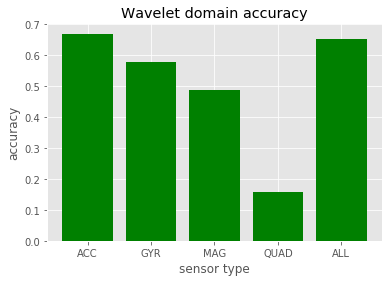

In [28]:
x = ['ACC', 'GYR', 'MAG', 'QUAD','ALL']
accuracy = [ACC_accuracy,GYR_accuracy,MAG_accuracy,QUAD_accuracy,ALL_accuracy]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='green')
plt.xlabel("sensor type")
plt.ylabel("accuracy")
plt.title("Wavelet domain accuracy")

plt.xticks(x_pos, x)

plt.show()

In [29]:
df_accuracy.to_csv('D:\projec\proj\data\Wavelet_domain_accuracy.csv', index=False)